# setup

In [1]:
%load_ext autoreload
%autoreload 2
%env CUBLAS_WORKSPACE_CONFIG=:4096:8

env: CUBLAS_WORKSPACE_CONFIG=:4096:8


In [2]:
from teren import dir_act_utils as dau, metric
from teren import utils as tu
from teren import direction, experiment_context
from transformer_lens import HookedTransformer
from teren.typing import *

device = tu.get_device_str()
print(f"{device=}")

device='cuda'


In [170]:
LAYER = 8
SEQ_LEN = 4
INFERENCE_TOKENS = 12_800
SEED = 0
tu.setup_determinism(SEED)
INFERENCE_BATCH_SIZE = INFERENCE_TOKENS // SEQ_LEN
print(f"{INFERENCE_BATCH_SIZE=}")

N_PROMPTS = INFERENCE_BATCH_SIZE * 10


input_ids = dau.get_input_ids(chunk=0, seq_len=SEQ_LEN)[:N_PROMPTS]
model = HookedTransformer.from_pretrained("gpt2-small", device=device)

INFERENCE_BATCH_SIZE=3200
Loaded pretrained model gpt2-small into HookedTransformer


In [171]:
exctx = experiment_context.ExperimentContext(
    model=model,
    layer=LAYER,
    input_ids=input_ids,
    acts_q_range=(0.2, 0.8),
    n_act=15,
    batch_size=INFERENCE_BATCH_SIZE,
)

  0%|          | 0/10 [00:00<?, ?it/s]

enc_dir_acts.nelement()=115706
dec_dir_acts.nelement()=6127


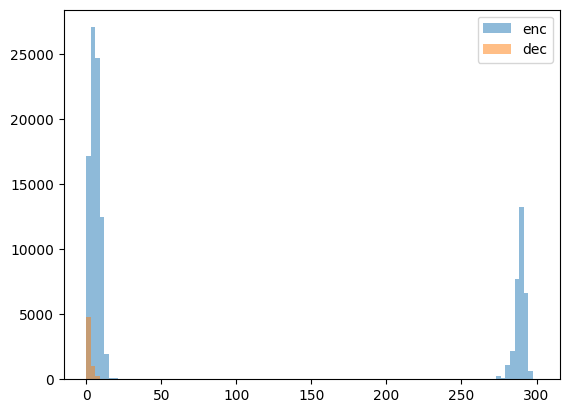

In [178]:
import matplotlib.pyplot as plt

dirs = []
i = 0
while True:
    # dir = torch.randn(model.cfg.d_model)
    # dir /= dir.norm()
    from sae_lens import SAE
    import random

    from teren.saes import SAE_ID_BY_LAYER_BY_FAMILY

    # sae_family = "gpt2-small-res-jb"
    sae_family = "gpt2-small-resid-post-v5-32k"
    sae_id = SAE_ID_BY_LAYER_BY_FAMILY[sae_family][LAYER]
    sae = SAE.from_pretrained(release=sae_family, sae_id=sae_id, device=device)[0]

    fids = random.randint(0, sae.cfg.d_sae - 1)
    enc_dir = sae.W_enc[:, fids].cpu()
    dec_dir = sae.W_dec[fids].cpu()
    enc_dir = direction.Direction(enc_dir, exctx)
    dec_dir = direction.Direction(dec_dir, exctx)
    enc_dir_acts = enc_dir.dir_acts  # + sae.b_enc[fids].cpu()
    enc_dir_acts = enc_dir_acts[enc_dir_acts > 0]
    dec_dir_acts = dec_dir.dir_acts  # + sae.b_enc[fids].cpu()
    dec_dir_acts = dec_dir_acts[dec_dir_acts > 0]

    min_act = min(enc_dir_acts.min(), dec_dir_acts.min()).item()
    max_act = max(enc_dir_acts.max(), dec_dir_acts.max()).item()

    # dirs.append(dir)
    plt.hist(
        enc_dir_acts.flatten(),
        bins=100,
        alpha=0.5,
        range=(min_act, max_act),
        label="enc",
    )
    plt.hist(
        dec_dir_acts.flatten(),
        bins=100,
        alpha=0.5,
        range=(min_act, max_act),
        label="dec",
    )
    plt.legend()
    print(f"{enc_dir_acts.nelement()=}")
    print(f"{dec_dir_acts.nelement()=}")
    # plt.vlines(-sae.b_enc[fids].cpu(), *plt.gca().get_ylim(), colors="red")
    # plt.vlines(dir.act_min, *plt.gca().get_ylim(), colors="red")
    # plt.vlines(dir.act_max, *plt.gca().get_ylim(), colors="red")
    # dir.process_metric_mm(metric.jsd_metric)
    # n_above_thresh = dir.res_by_metric[metric.jsd_metric].mm_sel.nelement()
    # print(f"{i=}, act range: {dir.act_min:.3f}, {dir.act_max:.3f}, {n_above_thresh=}")
    # dir.process_metric_cvx(metric.jsd_metric)
    # if n_above_thresh > 0:
    break
    i += 1
# len(dirs)

(array([    0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0., 32768.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.]),
 array([-0.5       , -0.49000001, -0.47999999, -0.47      , -0.46000001,
        -0.44999999, 

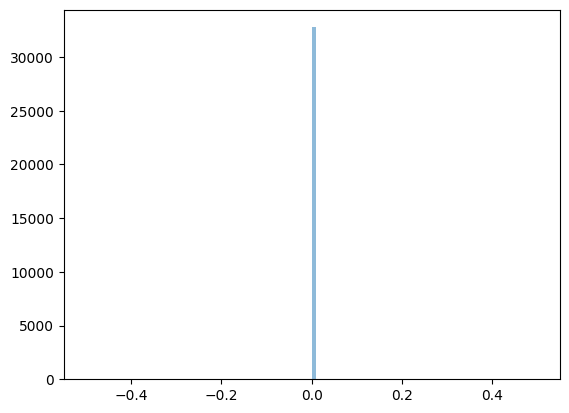

In [177]:
plt.hist(sae.b_enc.cpu().flatten(), bins=100, alpha=0.5, label="enc")

In [15]:
mm_hist = sum(dir.res_by_metric[metric.jsd_metric].mm_hist for dir in dirs)

In [16]:
hist_by_name = {
    "random": mm_hist,
}

color_by_name = {
    "sae": "255, 0, 0",
    "random": "0, 255, 0",
    "svd": "0, 0, 255",
}

In [17]:
import numpy as np
import plotly.graph_objects as go
import plotly.express as px


def plot_hist(hist_by_name, color_by_name, what):
    fig = go.Figure()
    # Add traces for each line and its shaded area
    for name, hist in hist_by_name.items():
        color = color_by_name[name]
        line_color = f"rgb({color})"
        shade_color = f"rgba({color}, 0.2)"
        fig.add_trace(
            go.Scatter(
                x=np.arange(len(hist)),
                y=hist / hist.sum(),
                line=dict(color=line_color, width=2),
                name=name,
                fill="tozeroy",  # Fill to y=0
                fillcolor=shade_color,  # Semi-transparent color
            )
        )
    title_params = f"{exctx.acts_q_range[0]*100:.0f}% and {exctx.acts_q_range[1]*100:.0f}%<br>(layer {LAYER}, {len(dirs)} dirs per type, {N_PROMPTS*SEQ_LEN//1000}k tokens)"
    fig.update_layout(
        title=f"distribution of {what} between activations set to {title_params}",
        xaxis_title=what,
        yaxis_title="density",
        legend_title="dirs type",
    )
    fig.show()

In [18]:
plot_hist(hist_by_name, color_by_name, "JSD")

In [19]:
cvx_hist = sum(
    torch.histogram(
        dir.res_by_metric[metric.jsd_metric].cvx_score,
        bins=100,
        range=(0.0, 1.0),
    )[0]
    for dir in dirs
)
cvx_hist_by_name = {
    "random": cvx_hist,
}
plot_hist(cvx_hist_by_name, color_by_name, "convexity score")

In [20]:
cvx_act_hist = sum(
    torch.histogram(
        dir.res_by_metric[metric.jsd_metric].cvx_act.float(),
        bins=exctx.n_act,
        range=(0.0, exctx.n_act - 1),
    )[0]
    for dir in dirs
)
cvx_act_hist_by_name = {
    "random": cvx_act_hist,
}
plot_hist(cvx_act_hist_by_name, color_by_name, "act lvl A maximizing convexity score")